In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(1,"/core/github/cryptoderiv-quant-lib")

from cdcqr.analytics.derivatives.vol_fitting.smoothing.utils import cumsum_getTEvents, fit_fun2
from scipy.interpolate import interp1d

from cryptoderiv_quantlib import VolModels
from cryptoderiv_quantlib import VolCurve, VolSurface, StickyOptions

from cdcqr.analytics.derivatives.vol_fitting.smoothing import kalman_filter as kf
from numpy.linalg import inv


In [3]:
from importlib import reload

In [4]:
MODEL_TO_TEST = "parabolic_linear6"
model = VolModels.vol_model(MODEL_TO_TEST)

In [5]:
df = pd.read_pickle('/core/data/fitted_vol_1.pkl')

In [6]:
df.tail()

,t,expire,df,localcurve,currcurve,err1,err2,currerr,changecurvecounter,localATM,...,currrightwing,ewmrightwing,localleftwing,currleftwing,ewmleftwing,localvol_atm,currvol_atm,ewmvol_atm,ewm_x,ewmerr
4690,1638598200000,1640937600000,ty s aiv biv ve...,<cryptoderiv_quantlib.volatility.data_objects....,<cryptoderiv_quantlib.volatility.data_objects....,0.001559,0.002039,0.001559,41,0.886565,...,0.190807,0.178519,0.233670,0.233670,0.222316,0.886565,0.886565,0.891364,"[-0.008184849839420576, -0.012794975213999589,...",0.002117
4691,1638598260000,1640937600000,ty s aiv biv ve...,<cryptoderiv_quantlib.volatility.data_objects....,<cryptoderiv_quantlib.volatility.data_objects....,0.001446,0.001526,0.001526,41,0.888559,...,0.190807,0.179639,0.244006,0.233670,0.224485,0.888559,0.886565,0.891084,"[-0.006683247187828269, -0.013294042114693146,...",0.001769
4692,1638598320000,1640937600000,ty s aiv biv ve...,<cryptoderiv_quantlib.volatility.data_objects....,<cryptoderiv_quantlib.volatility.data_objects....,0.001297,0.002112,0.001297,42,0.894292,...,0.182389,0.179914,0.240373,0.240373,0.226074,0.894292,0.894292,0.891404,"[-0.004825716465571812, -0.012683239846237397,...",0.001496
4693,1638598380000,1640937600000,ty s aiv biv ve...,<cryptoderiv_quantlib.volatility.data_objects....,<cryptoderiv_quantlib.volatility.data_objects....,0.001417,0.001569,0.001569,42,0.893078,...,0.182389,0.180924,0.225067,0.240373,0.225973,0.893078,0.894292,0.891572,"[-0.002975164140564585, -0.011853010891738638,...",0.001578
4694,1638598440000,1640937600000,ty s aiv biv ve...,<cryptoderiv_quantlib.volatility.data_objects....,<cryptoderiv_quantlib.volatility.data_objects....,0.001595,0.001707,0.001707,42,0.894365,...,0.182389,0.182227,0.224281,0.240373,0.225804,0.894365,0.894292,0.891851,"[-0.0012671767154857575, -0.011582756309418641...",0.001771


### 1) use vol_atm --> find rolling mean and std --> apply cusum

In [7]:
print(df.shape)
print(df.columns)
lbw = 50

(4695, 34)
Index(['t', 'expire', 'df', 'localcurve', 'currcurve', 'err1', 'err2',
       'currerr', 'changecurvecounter', 'localATM', 'currATM',
       'localskew_left', 'currskew_left', 'ewmskew_left', 'localskew_right',
       'currskew_right', 'ewmskew_right', 'localconv_left', 'currconv_left',
       'ewmconv_left', 'localconv_right', 'currconv_right', 'ewmconv_right',
       'localrightwing', 'currrightwing', 'ewmrightwing', 'localleftwing',
       'currleftwing', 'ewmleftwing', 'localvol_atm', 'currvol_atm',
       'ewmvol_atm', 'ewm_x', 'ewmerr'],
      dtype='object')


In [8]:
df['ma_localvol_atm'] = df['localvol_atm'].rolling(lbw).mean()
df['rstd_localvol_atm'] = df['localvol_atm'].rolling(lbw).std()
df['zscore_localvol_atm'] = (df['localvol_atm']-df['ma_localvol_atm'])/df['rstd_localvol_atm']

### 1.1) test a range of threshold for CUMSUM algo

In [9]:
h2events_ratio = {}
n = df.shape[0] - lbw
for h in np.linspace(0.5, 5, 100):
    m = len(cumsum_getTEvents(df['zscore_localvol_atm'], h))
    r = m/n
    h2events_ratio[h] = r

<AxesSubplot:xlabel='cumsum_threshold'>

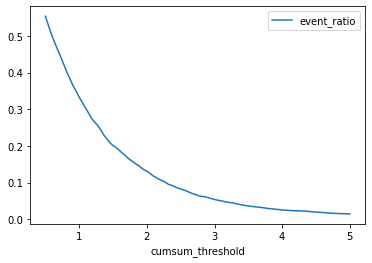

In [10]:
df_h2events_ratio = pd.DataFrame(h2events_ratio, index=[0]).T.reset_index()
df_h2events_ratio.columns = ['cumsum_threshold', 'event_ratio']
df_h2events_ratio = df_h2events_ratio.set_index('cumsum_threshold')
df_h2events_ratio.plot()

#### 1.2) take h = 3 for example

In [11]:
h = 3
interp1d(df_h2events_ratio.index, df_h2events_ratio['event_ratio'])([3])[0]

0.05403659849300323

In [12]:
cumsum_event_index = cumsum_getTEvents(df['zscore_localvol_atm'], h)
df['cumsum_event'] = False
df.loc[cumsum_event_index, ['cumsum_event']]=True
df['cumsum_event'].iloc[0]=True

C:\Users\Wang\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [13]:
df['cumsum_curve'] = df['localcurve']
df['cumsum_curve'] = df['cumsum_curve'].where(df['cumsum_event'], np.nan)
df['cumsum_curve'] = df['cumsum_curve'].ffill()

#### 1.3) apply metric to check is the CUMSUM algo with h = 3 is good or not?

In [14]:
df.head(2).T

,0,1
t,1638316800000,1638316860000
expire,1640937600000,1640937600000
df,ty s aiv biv ve...,ty s aiv biv ve...
localcurve,<cryptoderiv_quantlib.volatility.data_objects....,<cryptoderiv_quantlib.volatility.data_objects....
currcurve,<cryptoderiv_quantlib.volatility.data_objects....,<cryptoderiv_quantlib.volatility.data_objects....
err1,0.001184,0.001212
err2,0.001184,0.001223
currerr,0.001184,0.001223
changecurvecounter,0,0
localATM,0.799385,0.801711


In [15]:
error =  df[['cumsum_curve','df']].apply(lambda x: fit_fun2(*x), axis=1).mean(1)

<AxesSubplot:>

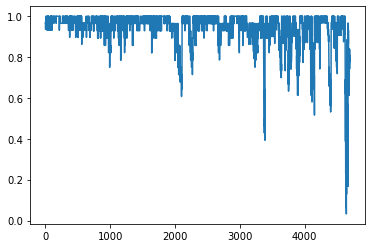

In [16]:
error.plot()

In [17]:
error.describe()

count    4695.000000
mean        0.942809
std         0.098647
min         0.032258
25%         0.931034
50%         0.965517
75%         1.000000
max         1.000000
dtype: float64

In [18]:
display(error.mean())

0.9428090018595959

### 2) at each time t, use the time series of mid iv of each strke = miv = (biv+aiv)/2 --> find the mean and std --> aggregate the z value --> apply cusum (or some variation of this)

In [19]:
df0 = pd.read_pickle('/core/data/vol_smoothing_base_1.pkl')

In [20]:
display(df0.head(2))
display(df.head(2))

,tm,expire,strike,ty,s,aiv,biv,vega,params
0,1638316800000,1640937600000,22000.0,-1,57406.67,1.4606,1.3408,2.40936,{}
1,1638316800000,1640937600000,24000.0,-1,57439.75,1.3375,1.2269,2.60587,{}


,t,expire,df,localcurve,currcurve,err1,err2,currerr,changecurvecounter,localATM,...,localvol_atm,currvol_atm,ewmvol_atm,ewm_x,ewmerr,ma_localvol_atm,rstd_localvol_atm,zscore_localvol_atm,cumsum_event,cumsum_curve
0,1638316800000,1640937600000,ty s aiv biv ve...,<cryptoderiv_quantlib.volatility.data_objects....,<cryptoderiv_quantlib.volatility.data_objects....,0.001184,0.001184,0.001184,0,0.799385,...,0.799385,0.799385,0.799385,"[0.05706715921572881, -0.025751727294213003, 0...",0.001184,NaN,NaN,NaN,True,<cryptoderiv_quantlib.volatility.data_objects....
1,1638316860000,1640937600000,ty s aiv biv ve...,<cryptoderiv_quantlib.volatility.data_objects....,<cryptoderiv_quantlib.volatility.data_objects....,0.001212,0.001223,0.001223,0,0.801711,...,0.801711,0.799385,0.800609,"[0.05493853329443952, -0.02816033204865347, 0....",0.001209,NaN,NaN,NaN,False,<cryptoderiv_quantlib.volatility.data_objects....


In [21]:
df0['diff'] = np.abs(df0['s'] - df0['strike'])

df0a = df0.loc[df0.groupby("tm")["diff"].idxmin()]

In [22]:
df1 = pd.merge(left=df, right=df0a[['tm','aiv','biv',]], left_on=['t'], right_on=['tm'], how='left').groupby('t').first().reset_index()

In [23]:
df1.shape

(4695, 42)

In [24]:
df1['miv'] = 0.5*(df1['biv'] + df1['aiv'])

In [25]:
df1['ma_miv'] = df1['miv'].rolling(lbw).mean()
df1['rstd_miv'] = df1['miv'].rolling(lbw).std()
df1['zscore_miv'] = (df1['miv']-df1['ma_miv'])/df1['rstd_miv']

In [26]:
cumsum_event_index = cumsum_getTEvents(df1['zscore_miv'], h)
df1['cumsum_event'] = False
df1.loc[cumsum_event_index, ['cumsum_event']]=True
df1['cumsum_event'].iloc[0]=True

C:\Users\Wang\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [27]:
df1['cumsum_curve'] = df1['localcurve']
df1['cumsum_curve'] = df1['cumsum_curve'].where(df1['cumsum_event'], np.nan)
df1['cumsum_curve'] = df1['cumsum_curve'].ffill()

#### apply metric to check is the CUMSUM algo with h = 3 is good or not?

In [28]:
error =  df1[['cumsum_curve','df']].apply(lambda x: fit_fun2(*x), axis=1).mean(1)

<AxesSubplot:>

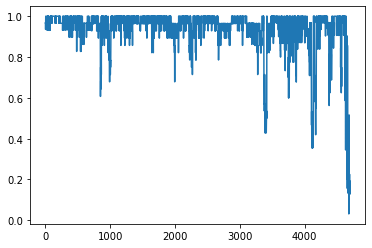

In [29]:
error.plot()

In [30]:
display(error.describe())

count    4695.000000
mean        0.942194
std         0.110166
min         0.031250
25%         0.931034
50%         0.965517
75%         1.000000
max         1.000000
dtype: float64

### 3) at each time t, use the spread = aiv - biv as a measure of std (maybe spread = 2 std) --> use miv as the mean --> z value --> aggregate --> apply cusum

In [31]:
df2 = df1.copy()
df2['iv_range'] = df2['biv'] - df2['aiv']
df2['normalized_miv'] = (df2['miv']-df2['ma_miv'])/df2['iv_range']
# try more methods

In [32]:
cumsum_event_index = cumsum_getTEvents(df2['normalized_miv'], h)
df2['cumsum_event'] = False
df2.loc[cumsum_event_index, ['cumsum_event']]=True
df2['cumsum_event'].iloc[0]=True

C:\Users\Wang\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [33]:
df2['cumsum_curve'] = df2['localcurve']
df2['cumsum_curve'] = df2['cumsum_curve'].where(df2['cumsum_event'], np.nan)
df2['cumsum_curve'] = df2['cumsum_curve'].ffill()

#### apply metric to check is the CUMSUM algo with h = 3 is good or not?
     * plot w.r.t time
     * confluence

In [34]:
error2 =  df2[['cumsum_curve','df']].apply(lambda x: fit_fun2(*x), axis=1).mean(1)

<AxesSubplot:>

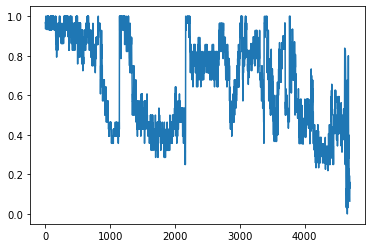

In [35]:
error2.plot()

In [36]:
error2.describe()

count    4695.000000
mean        0.660902
std         0.224187
min         0.000000
25%         0.464286
50%         0.678571
75%         0.862069
max         1.000000
dtype: float64

## Kalman filter smoothing

In [38]:
reload(kf)

<module 'cdcqr.analytics.derivatives.vol_fitting.smoothing.kalman_filter' from 'c:\\core\\github\\cdcqr\\cdcqr\\analytics\\derivatives\\vol_fitting\\smoothing\\kalman_filter.py'>

In [39]:
kf.simple_kalman_filter?

Signature: kf.simple_kalman_filter(z, x_prev, sigma0, h_mat, sigma1, sigma2)
Docstring: <no docstring>
File:      c:\core\github\cdcqr\cdcqr\analytics\derivatives\vol_fitting\smoothing\kalman_filter.py
Type:      function


In [40]:
pre_params = df['localcurve'].iloc[0].params
pre_x = np.array([1, pre_params['skew_left'], pre_params['skew_right'], pre_params['conv_left'], pre_params['conv_right'], pre_params['rightwing'], pre_params['leftwing']])
pre_x

array([ 1.        ,  0.05706716, -0.02575173,  0.01570563,  0.05909604,
        0.16671032,  0.22418722])

In [41]:
df1 = df['df'][1]

In [42]:
kright = 1.5
kleft = -1.5

In [43]:
S = df1['s'].iloc[0]

volATM = interp1d(df1.index, df1['m'])([S])[0]

In [44]:
df1.head(5)

,ty,s,aiv,biv,vega,params,logKFtau,m,myvol,insidebidask
strike,,,,,,,,,,
22000.0,-1,57322.76,1.4586,1.3389,2.42223,{},-3.322007,1.39875,1.328794,False
24000.0,-1,57332.53,1.3348,1.2244,2.62755,{},-3.020765,1.27960,1.261259,True
26000.0,-1,57338.50,1.2210,1.1191,2.84909,{},-2.743466,1.17005,1.199093,True
28000.0,-1,57332.53,1.1810,1.0213,3.62115,{},-2.486032,1.10115,1.141379,True
30000.0,-1,57338.50,1.1263,1.0170,5.31596,{},-2.247064,1.07165,1.087806,True


In [45]:
# observations
z = df1['m'].values

In [46]:
# transformation matrix

df1['col0'] = volATM
df1['col1'] = (df1['logKFtau']<0).astype(int)*kleft
df1['col2'] = (df1['logKFtau']>0).astype(int)*kright
df1['col3'] = (df1['logKFtau']<0).astype(int)*kleft**2
df1['col4'] = (df1['logKFtau']>0).astype(int)*kright**2
df1['col5'] = (df1['logKFtau']>kright).astype(int)*(df1['logKFtau']-kright)
df1['col6'] = (df1['logKFtau']<kleft).astype(int)*(df1['logKFtau']-kleft)

h_mat = df1[['col0','col1','col2','col3','col4','col5','col6']].values

In [47]:
df['localcurve'][0].params

{'skew_left': 0.05706715921572881,
 'skew_right': -0.025751727294213003,
 'conv_left': 0.015705629140172088,
 'conv_right': 0.05909604206894494,
 'rightwing': 0.16671031852197268,
 'leftwing': 0.2241872198597274,
 'vol_atm': 0.7993849925000001,
 'ref_forward': 57406.67,
 'fitness_error': 0.0011839137296786638,
 'kleft': -1.5,
 'kright': 1.5}

In [48]:
df_parames = df[['localskew_left','localskew_right','localconv_left','localconv_right','localrightwing','localleftwing']]#['localcurve'][10].params

In [49]:
df_parames.describe()

,localskew_left,localskew_right,localconv_left,localconv_right,localrightwing,localleftwing
count,4695.000000,4695.000000,4695.000000,4695.000000,4695.000000,4695.000000
mean,0.059285,-0.056082,0.036465,0.076680,0.149398,0.191669
std,0.035055,0.049971,0.023359,0.037604,0.025326,0.017823
min,-1.005764,-0.254889,-0.460222,-0.909251,0.090812,-0.212410
25%,0.050723,-0.069368,0.029282,0.072692,0.135293,0.181479
50%,0.061041,-0.059877,0.033873,0.078001,0.151638,0.190767
75%,0.069507,-0.046382,0.042451,0.083750,0.162485,0.201389
max,0.989801,1.209404,0.743468,0.167790,0.597542,0.579589


In [122]:
pre_params = df['localcurve'].iloc[0].params
pre_x = np.array([1, pre_params['skew_left'], pre_params['skew_right'], pre_params['conv_left'], pre_params['conv_right'], pre_params['rightwing'], pre_params['leftwing']])
reload(kf)
display(pre_x)
sigma0 = 0.01
sigma1 = 0.01
sigma2 = 0.0000001
kf_params = kf.simple_kalman_filter(z, pre_x, sigma0, h_mat, sigma1, sigma2)
display(kf_params)

array([ 1.        ,  0.05706716, -0.02575173,  0.01570563,  0.05909604,
        0.16671032,  0.22418722])

array([ 1.00597546,  0.03328932, -0.03950773,  0.05137239,  0.03846204,
        0.24379721, -0.33129058])

In [123]:
df['kfcurve'] = None
df['kfcurve'].iloc[0] = df['localcurve'].iloc[0]

localcurve0 =  df['localcurve'].iloc[0]
pre_params = localcurve0.params
pre_x = np.array([1, pre_params['skew_left'], pre_params['skew_right'], pre_params['conv_left'], pre_params['conv_right'], pre_params['rightwing'], pre_params['leftwing']])
for i in range(1, df.shape[0]):        
    print('---------------------------', i, '---------------------------')
    
    df1 = df['df'].iloc[i]
    
    pre_params = df['kfcurve'].iloc[i-1].params
    kleft = pre_params['kleft']
    kright = pre_params['kright']
    
    S = df1['s'].iloc[0]
    volATM = interp1d(df1.index, df1['m'])([S])[0]
    df1['col0'] = volATM
    df1['col1'] = (df1['logKFtau']<0).astype(int)*kleft
    df1['col2'] = (df1['logKFtau']>0).astype(int)*kright
    df1['col3'] = (df1['logKFtau']<0).astype(int)*kleft**2
    df1['col4'] = (df1['logKFtau']>0).astype(int)*kright**2
    df1['col5'] = (df1['logKFtau']>kright).astype(int)*(df1['logKFtau']-kright)
    df1['col6'] = (df1['logKFtau']<kleft).astype(int)*(df1['logKFtau']-kleft)
    h_mat = df1[['col0','col1','col2','col3','col4','col5','col6']].values
    
 
    pre_x = np.array([1, pre_params['skew_left'], pre_params['skew_right'], pre_params['conv_left'], pre_params['conv_right'], pre_params['rightwing'], pre_params['leftwing']])
    z = df1['m'].values
    kf_params = kf.simple_kalman_filter(z, pre_x, sigma0, h_mat, sigma1, sigma2)

    print(pre_x)
    print(kf_params)
    
    lc_i = df['localcurve'].iloc[i]
    kfc_param_dict = lc_i.params
    kfc_param_dict['skew_left'] = kf_params[1]
    kfc_param_dict['skew_right'] = kf_params[2]
    kfc_param_dict['conv_left'] = kf_params[3]
    kfc_param_dict['conv_right'] = kf_params[4]
    kfc_param_dict['rightwing'] = kf_params[5]
    kfc_param_dict['leftwing'] = kf_params[6]
    kfc = VolCurve(lc_i.expiry_time_ms, kfc_param_dict)
    
    df['kfcurve'].iloc[i] = kfc

C:\Users\Wang\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


--------------------------- 1 ---------------------------
[ 1.          0.05706716 -0.02575173  0.01570563  0.05909604  0.16671032
  0.22418722]
[ 1.00448677  0.03599955 -0.03842461  0.04730705  0.04008673  0.22314374
 -0.27991113]
--------------------------- 2 ---------------------------
[ 1.          0.03599955 -0.03842461  0.04730705  0.04008673  0.22314374
 -0.27991113]
[ 1.00022802  0.03581685 -0.03818218  0.04758109  0.04045036  0.22320179
 -0.27915578]
--------------------------- 3 ---------------------------
[ 1.          0.03581685 -0.03818218  0.04758109  0.04045036  0.22320179
 -0.27915578]
[ 1.00003665  0.03601001 -0.03792076  0.04729135  0.04084249  0.2212123
 -0.27979037]
--------------------------- 4 ---------------------------
[ 1.          0.03601001 -0.03792076  0.04729135  0.04084249  0.2212123
 -0.27979037]
[ 1.00057951  0.03484953 -0.0379989   0.04903207  0.04072529  0.22526879
 -0.26691306]
--------------------------- 5 ---------------------------
[ 1.          0.

#### apply metric to check if the Kalman filter with sigma=0.001 is good or not?
     * plot w.r.t time
     * confluence

In [124]:
error3 =  df[['kfcurve','df']].apply(lambda x: fit_fun2(*x), axis=1).mean(1)

<AxesSubplot:>

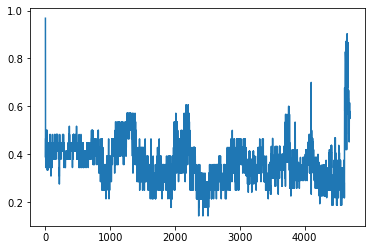

In [125]:
error3.plot()

In [126]:
error3.describe()

count    4695.000000
mean        0.367491
std         0.087708
min         0.142857
25%         0.312500
50%         0.357143
75%         0.413793
max         0.967742
dtype: float64